In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/handy.geraldy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 16


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(424881, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,160305107C1#02,160305107C1,160305107,1,2022_03,6,NV,48MUB,-14.417054,-15.453288,...,-14.411136,-14.507049,-14.778535,-14.411583,-14.427826,1603,1,1.333619,R17C8,0.475810
1,160305107C1#06,160305107C1,160305107,1,2022_03,6,NV,48MUB,-12.813298,-12.910084,...,-14.241682,-14.623736,-15.423254,-13.421648,-13.539691,1603,1,1.333619,R0C17,0.470588
2,160305108B2#11,160305108B2,160305108,1,2022_03,6,NV,48MUB,-15.112636,-14.575656,...,-15.117046,-14.210211,-13.167871,-14.001276,-13.880877,1603,1,4.148099,R8C3,0.544771
6,160305108B2#12,160305108B2,160305108,1,2022_03,6,NV,48MUB,-15.153728,-14.256364,...,-16.040712,-14.209383,-12.665653,-13.330966,-13.522510,1603,1,4.148099,R6C9,0.409669
10,160305108B2#13,160305108B2,160305108,1,2022_03,6,NV,48MUB,-15.317593,-14.713882,...,-16.066772,-14.741725,-14.202780,-13.020895,-13.985903,1603,1,4.148099,R6C9,0.409669


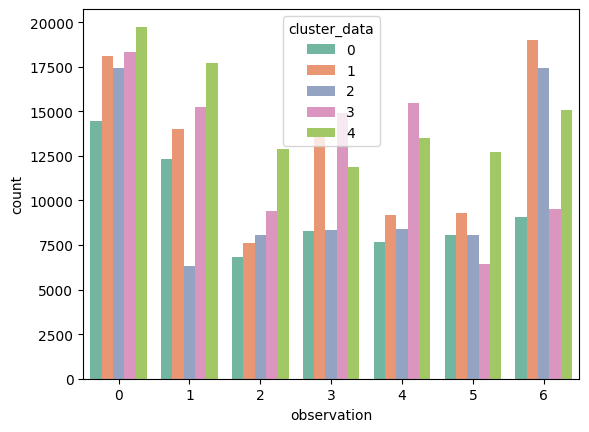

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-16 15:31:05,462] A new study created in memory with name: no-name-3e4e7967-ed71-4c03-a6fd-064191ed413d


[6 1 3 4 2 0 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 15:31:26,850] Trial 0 finished with value: 0.803266087455304 and parameters: {'max_depth': 8, 'learning_rate': 0.09207903205066158, 'reg_lambda': 3.9294884866152007, 'min_child_weight': 79}. Best is trial 0 with value: 0.803266087455304.


[I 2024-10-16 15:31:57,123] Trial 1 finished with value: 0.8052092935560289 and parameters: {'max_depth': 10, 'learning_rate': 0.07586383786700272, 'reg_lambda': 3.150493037769875, 'min_child_weight': 91}. Best is trial 1 with value: 0.8052092935560289.


[I 2024-10-16 15:32:28,576] Trial 2 finished with value: 0.8005659742182946 and parameters: {'max_depth': 7, 'learning_rate': 0.07870073494681748, 'reg_lambda': 0.14882133337308484, 'min_child_weight': 96}. Best is trial 1 with value: 0.8052092935560289.


[I 2024-10-16 15:33:50,196] Trial 3 finished with value: 0.7966319641761976 and parameters: {'max_depth': 6, 'learning_rate': 0.018089495342636264, 'reg_lambda': 4.123330490721615, 'min_child_weight': 65}. Best is trial 1 with value: 0.8052092935560289.


[I 2024-10-16 15:35:48,078] Trial 4 finished with value: 0.8006455804439793 and parameters: {'max_depth': 9, 'learning_rate': 0.010166454262575455, 'reg_lambda': 1.5938980811131218, 'min_child_weight': 66}. Best is trial 1 with value: 0.8052092935560289.


[I 2024-10-16 15:36:47,145] Trial 5 finished with value: 0.8013313280205231 and parameters: {'max_depth': 7, 'learning_rate': 0.033992891349390104, 'reg_lambda': 3.7625619167280386, 'min_child_weight': 95}. Best is trial 1 with value: 0.8052092935560289.


[I 2024-10-16 15:37:16,775] Trial 6 finished with value: 0.8059541424677503 and parameters: {'max_depth': 10, 'learning_rate': 0.07700080077241848, 'reg_lambda': 4.302475274628808, 'min_child_weight': 92}. Best is trial 6 with value: 0.8059541424677503.


[I 2024-10-16 15:38:45,602] Trial 7 finished with value: 0.8039136628113356 and parameters: {'max_depth': 9, 'learning_rate': 0.02643350818607889, 'reg_lambda': 0.23178185544346452, 'min_child_weight': 82}. Best is trial 6 with value: 0.8059541424677503.


[I 2024-10-16 15:40:21,150] Trial 8 finished with value: 0.8021893772476658 and parameters: {'max_depth': 8, 'learning_rate': 0.03182300913803295, 'reg_lambda': 1.568039999349884, 'min_child_weight': 95}. Best is trial 6 with value: 0.8059541424677503.


[I 2024-10-16 15:41:18,859] Trial 9 finished with value: 0.8041126281734332 and parameters: {'max_depth': 9, 'learning_rate': 0.036136506015715164, 'reg_lambda': 2.924113068087455, 'min_child_weight': 90}. Best is trial 6 with value: 0.8059541424677503.


[I 2024-10-16 15:41:54,491] Trial 10 finished with value: 0.8071801057630563 and parameters: {'max_depth': 10, 'learning_rate': 0.05460669473984336, 'reg_lambda': 4.927869057933277, 'min_child_weight': 57}. Best is trial 10 with value: 0.8071801057630563.


[I 2024-10-16 15:42:22,721] Trial 11 finished with value: 0.8059048108717765 and parameters: {'max_depth': 10, 'learning_rate': 0.05716697850777114, 'reg_lambda': 4.956512455694927, 'min_child_weight': 50}. Best is trial 10 with value: 0.8071801057630563.


[I 2024-10-16 15:42:54,854] Trial 12 finished with value: 0.8090387449453286 and parameters: {'max_depth': 10, 'learning_rate': 0.0586179676681119, 'reg_lambda': 4.9798041164041305, 'min_child_weight': 50}. Best is trial 12 with value: 0.8090387449453286.


[I 2024-10-16 15:43:32,046] Trial 13 finished with value: 0.8074748582362551 and parameters: {'max_depth': 10, 'learning_rate': 0.05252851695465162, 'reg_lambda': 4.968660401656705, 'min_child_weight': 50}. Best is trial 12 with value: 0.8090387449453286.


[I 2024-10-16 15:44:09,292] Trial 14 finished with value: 0.805710886538317 and parameters: {'max_depth': 9, 'learning_rate': 0.05302641393522603, 'reg_lambda': 2.1083607017469834, 'min_child_weight': 52}. Best is trial 12 with value: 0.8090387449453286.


[I 2024-10-16 15:44:43,021] Trial 15 finished with value: 0.8039663547902887 and parameters: {'max_depth': 8, 'learning_rate': 0.06311502407592424, 'reg_lambda': 4.560322662849776, 'min_child_weight': 64}. Best is trial 12 with value: 0.8090387449453286.


[I 2024-10-16 15:45:29,802] Trial 16 finished with value: 0.8082691596551502 and parameters: {'max_depth': 10, 'learning_rate': 0.04567136843041536, 'reg_lambda': 3.50576180485814, 'min_child_weight': 58}. Best is trial 12 with value: 0.8090387449453286.


[I 2024-10-16 15:45:57,516] Trial 17 finished with value: 0.8051343681996229 and parameters: {'max_depth': 9, 'learning_rate': 0.06652700837148254, 'reg_lambda': 3.400239871039118, 'min_child_weight': 59}. Best is trial 12 with value: 0.8090387449453286.


[I 2024-10-16 15:46:36,790] Trial 18 finished with value: 0.8027168815353681 and parameters: {'max_depth': 7, 'learning_rate': 0.043309135905570034, 'reg_lambda': 2.215777190031991, 'min_child_weight': 71}. Best is trial 12 with value: 0.8090387449453286.


[I 2024-10-16 15:47:15,403] Trial 19 finished with value: 0.806869697129115 and parameters: {'max_depth': 10, 'learning_rate': 0.0447685540013336, 'reg_lambda': 3.5546853436883734, 'min_child_weight': 57}. Best is trial 12 with value: 0.8090387449453286.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.0586179676681119, 'reg_lambda': 4.9798041164041305, 'min_child_weight': 50}
Best Score: 0.8090387449453286
Start the modelling


[0]	train-mlogloss:1.82604	eval-mlogloss:1.83953


[100]	train-mlogloss:0.21665	eval-mlogloss:0.56431


[200]	train-mlogloss:0.11246	eval-mlogloss:0.53368


[300]	train-mlogloss:0.06679	eval-mlogloss:0.53181


[400]	train-mlogloss:0.04571	eval-mlogloss:0.53728


[500]	train-mlogloss:0.03427	eval-mlogloss:0.54565


[600]	train-mlogloss:0.02778	eval-mlogloss:0.55365


[700]	train-mlogloss:0.02340	eval-mlogloss:0.56040


[800]	train-mlogloss:0.02039	eval-mlogloss:0.56640


[900]	train-mlogloss:0.01799	eval-mlogloss:0.57258


[1000]	train-mlogloss:0.01618	eval-mlogloss:0.57792


[1100]	train-mlogloss:0.01474	eval-mlogloss:0.58316


[1200]	train-mlogloss:0.01352	eval-mlogloss:0.58776


[1266]	train-mlogloss:0.01285	eval-mlogloss:0.59112


[0]	train-mlogloss:1.82566	eval-mlogloss:1.84037


[100]	train-mlogloss:0.21931	eval-mlogloss:0.58370


[200]	train-mlogloss:0.11058	eval-mlogloss:0.55693


[300]	train-mlogloss:0.06789	eval-mlogloss:0.56187


[400]	train-mlogloss:0.04639	eval-mlogloss:0.57046


[500]	train-mlogloss:0.03520	eval-mlogloss:0.57967


[600]	train-mlogloss:0.02853	eval-mlogloss:0.58828


[700]	train-mlogloss:0.02385	eval-mlogloss:0.59648


[800]	train-mlogloss:0.02069	eval-mlogloss:0.60334


[900]	train-mlogloss:0.01819	eval-mlogloss:0.61054


[1000]	train-mlogloss:0.01630	eval-mlogloss:0.61683


[1100]	train-mlogloss:0.01473	eval-mlogloss:0.62252


[1200]	train-mlogloss:0.01351	eval-mlogloss:0.62762


[1217]	train-mlogloss:0.01333	eval-mlogloss:0.62851


[0]	train-mlogloss:1.82544	eval-mlogloss:1.83978


[100]	train-mlogloss:0.21243	eval-mlogloss:0.56979


[200]	train-mlogloss:0.10797	eval-mlogloss:0.53958


[300]	train-mlogloss:0.06385	eval-mlogloss:0.54011


[400]	train-mlogloss:0.04412	eval-mlogloss:0.54862


[500]	train-mlogloss:0.03363	eval-mlogloss:0.55716


[600]	train-mlogloss:0.02724	eval-mlogloss:0.56614


[700]	train-mlogloss:0.02298	eval-mlogloss:0.57410


[800]	train-mlogloss:0.01998	eval-mlogloss:0.58077


[900]	train-mlogloss:0.01766	eval-mlogloss:0.58752


[1000]	train-mlogloss:0.01590	eval-mlogloss:0.59349


[1100]	train-mlogloss:0.01448	eval-mlogloss:0.59913


[1200]	train-mlogloss:0.01330	eval-mlogloss:0.60434


[1238]	train-mlogloss:0.01293	eval-mlogloss:0.60645


[0]	train-mlogloss:1.82313	eval-mlogloss:1.83589


[50]	train-mlogloss:0.40612	eval-mlogloss:0.66594


[100]	train-mlogloss:0.23487	eval-mlogloss:0.56436


[150]	train-mlogloss:0.16949	eval-mlogloss:0.54132


[200]	train-mlogloss:0.12862	eval-mlogloss:0.53254


[250]	train-mlogloss:0.10009	eval-mlogloss:0.52929


[300]	train-mlogloss:0.07873	eval-mlogloss:0.52881


[336]	train-mlogloss:0.06796	eval-mlogloss:0.52982



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87     10133
           1       0.88      0.92      0.90      8637
           2       0.88      0.91      0.89      4765
           3       0.90      0.91      0.90      5797
           4       0.87      0.87      0.87      5367
           5       0.67      0.56      0.61      5637
           6       0.64      0.63      0.63      6362

    accuracy                           0.82     46698
   macro avg       0.81      0.81      0.81     46698
weighted avg       0.82      0.82      0.82     46698



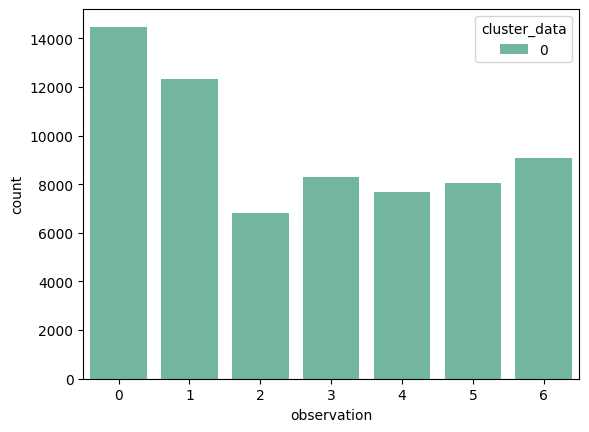

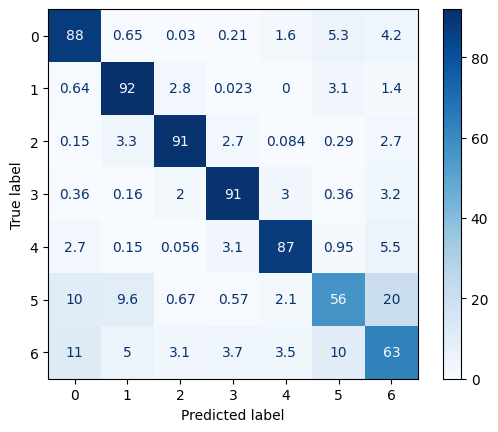

{'average_accuracy': 0.8199170539149553, 'average_f1_macro': 0.8102704443209419, 'average_f1_micro': 0.8199170539149553, 'average_auc': 0.9655707423313302, 'average_acc_kelas_generatif': 0.9126802367479977, 'average_acc_fase_padi': 0.8972269055887452}
{'val_accuracy': 0.8210630005567691, 'val_f1_macro': 0.8117666077077271, 'val_f1_micro': 0.8210630005567691, 'val_auc': 0.9663542619295706, 'val_acc_kelas_generatif': 0.9085734000345006, 'val_acc_fase_padi': 0.9052348774729301, 'val_relative_acc': 99.52379221345741}
CLUSTER:  1


[I 2024-10-16 15:49:14,857] A new study created in memory with name: no-name-d4d61f85-be57-49f7-a9f9-6168322370e0


[6 2 1 4 3 0 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 15:50:00,827] Trial 0 finished with value: 0.8528954911178195 and parameters: {'max_depth': 10, 'learning_rate': 0.07843702270275346, 'reg_lambda': 0.5665489009955318, 'min_child_weight': 55}. Best is trial 0 with value: 0.8528954911178195.


[I 2024-10-16 15:51:07,133] Trial 1 finished with value: 0.8537122854122764 and parameters: {'max_depth': 7, 'learning_rate': 0.04646958425402291, 'reg_lambda': 2.9287855615422402, 'min_child_weight': 82}. Best is trial 1 with value: 0.8537122854122764.


[I 2024-10-16 15:52:23,274] Trial 2 finished with value: 0.853994236831523 and parameters: {'max_depth': 9, 'learning_rate': 0.055079488378026085, 'reg_lambda': 0.931413620372608, 'min_child_weight': 79}. Best is trial 2 with value: 0.853994236831523.


[I 2024-10-16 15:52:52,593] Trial 3 finished with value: 0.853782110783515 and parameters: {'max_depth': 6, 'learning_rate': 0.09370303830470013, 'reg_lambda': 1.924406267286281, 'min_child_weight': 77}. Best is trial 2 with value: 0.853994236831523.


[I 2024-10-16 15:53:29,059] Trial 4 finished with value: 0.8527937606378161 and parameters: {'max_depth': 6, 'learning_rate': 0.07053890031913461, 'reg_lambda': 4.288092277634869, 'min_child_weight': 91}. Best is trial 2 with value: 0.853994236831523.


[I 2024-10-16 15:54:06,201] Trial 5 finished with value: 0.8532687068982922 and parameters: {'max_depth': 8, 'learning_rate': 0.055143687864473455, 'reg_lambda': 4.391604818902191, 'min_child_weight': 62}. Best is trial 2 with value: 0.853994236831523.


[I 2024-10-16 15:55:18,719] Trial 6 finished with value: 0.8547570435138835 and parameters: {'max_depth': 7, 'learning_rate': 0.03648175189823444, 'reg_lambda': 1.8392711962476578, 'min_child_weight': 77}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 15:56:03,544] Trial 7 finished with value: 0.8540566134800595 and parameters: {'max_depth': 7, 'learning_rate': 0.05520966717848947, 'reg_lambda': 3.473064701520157, 'min_child_weight': 64}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 15:56:46,451] Trial 8 finished with value: 0.8534827412534596 and parameters: {'max_depth': 6, 'learning_rate': 0.06892372542258635, 'reg_lambda': 3.2534281196779182, 'min_child_weight': 76}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 15:57:48,977] Trial 9 finished with value: 0.8544591363287591 and parameters: {'max_depth': 9, 'learning_rate': 0.038938067446758894, 'reg_lambda': 2.7168825468060858, 'min_child_weight': 61}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 15:59:57,395] Trial 10 finished with value: 0.8507956226157608 and parameters: {'max_depth': 8, 'learning_rate': 0.015588079824020447, 'reg_lambda': 1.6190128084801303, 'min_child_weight': 95}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:01:05,354] Trial 11 finished with value: 0.8541697105808131 and parameters: {'max_depth': 10, 'learning_rate': 0.02852197927588212, 'reg_lambda': 2.1111945571720057, 'min_child_weight': 66}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:02:15,796] Trial 12 finished with value: 0.85426036713342 and parameters: {'max_depth': 9, 'learning_rate': 0.03653095264146257, 'reg_lambda': 1.2969746432130667, 'min_child_weight': 51}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:04:46,402] Trial 13 finished with value: 0.8482401915729031 and parameters: {'max_depth': 8, 'learning_rate': 0.010385355417429954, 'reg_lambda': 2.573010934573091, 'min_child_weight': 69}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:06:06,573] Trial 14 finished with value: 0.8539168456618906 and parameters: {'max_depth': 9, 'learning_rate': 0.028150742146200808, 'reg_lambda': 3.721448883248226, 'min_child_weight': 88}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:06:54,482] Trial 15 finished with value: 0.853832421022863 and parameters: {'max_depth': 7, 'learning_rate': 0.03921114992691317, 'reg_lambda': 2.3894521529441124, 'min_child_weight': 57}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:08:22,504] Trial 16 finished with value: 0.8525253163070889 and parameters: {'max_depth': 8, 'learning_rate': 0.02380285343403661, 'reg_lambda': 4.952762113877319, 'min_child_weight': 71}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:09:22,541] Trial 17 finished with value: 0.8545067115101235 and parameters: {'max_depth': 9, 'learning_rate': 0.04290193212736297, 'reg_lambda': 0.33439747190130076, 'min_child_weight': 85}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:10:16,052] Trial 18 finished with value: 0.8545437327766553 and parameters: {'max_depth': 7, 'learning_rate': 0.044117429568098755, 'reg_lambda': 0.11612437559490596, 'min_child_weight': 85}. Best is trial 6 with value: 0.8547570435138835.


[I 2024-10-16 16:11:08,986] Trial 19 finished with value: 0.8542545293104241 and parameters: {'max_depth': 7, 'learning_rate': 0.06458457841091153, 'reg_lambda': 0.2082642251330949, 'min_child_weight': 97}. Best is trial 6 with value: 0.8547570435138835.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.03648175189823444, 'reg_lambda': 1.8392711962476578, 'min_child_weight': 77}
Best Score: 0.8547570435138835
Start the modelling


[0]	train-mlogloss:1.86619	eval-mlogloss:1.86818


[100]	train-mlogloss:0.38591	eval-mlogloss:0.48884


[200]	train-mlogloss:0.24710	eval-mlogloss:0.40583


[300]	train-mlogloss:0.18730	eval-mlogloss:0.38572


[400]	train-mlogloss:0.14361	eval-mlogloss:0.37644


[500]	train-mlogloss:0.11393	eval-mlogloss:0.37146


[600]	train-mlogloss:0.09263	eval-mlogloss:0.36964


[700]	train-mlogloss:0.07621	eval-mlogloss:0.36932


[800]	train-mlogloss:0.06464	eval-mlogloss:0.37064


[900]	train-mlogloss:0.05583	eval-mlogloss:0.37281


[1000]	train-mlogloss:0.04874	eval-mlogloss:0.37556


[1100]	train-mlogloss:0.04318	eval-mlogloss:0.37850


[1200]	train-mlogloss:0.03863	eval-mlogloss:0.38122


[1300]	train-mlogloss:0.03485	eval-mlogloss:0.38392


[1400]	train-mlogloss:0.03170	eval-mlogloss:0.38710


[1500]	train-mlogloss:0.02906	eval-mlogloss:0.39024


[1600]	train-mlogloss:0.02675	eval-mlogloss:0.39373


[1638]	train-mlogloss:0.02602	eval-mlogloss:0.39499


[0]	train-mlogloss:1.86697	eval-mlogloss:1.86834


[100]	train-mlogloss:0.39729	eval-mlogloss:0.48264


[200]	train-mlogloss:0.25375	eval-mlogloss:0.39555


[300]	train-mlogloss:0.19166	eval-mlogloss:0.37440


[400]	train-mlogloss:0.14976	eval-mlogloss:0.36360


[500]	train-mlogloss:0.11906	eval-mlogloss:0.35846


[600]	train-mlogloss:0.09711	eval-mlogloss:0.35536


[700]	train-mlogloss:0.08154	eval-mlogloss:0.35437


[800]	train-mlogloss:0.06996	eval-mlogloss:0.35504


[900]	train-mlogloss:0.06035	eval-mlogloss:0.35622


[1000]	train-mlogloss:0.05257	eval-mlogloss:0.35804


[1100]	train-mlogloss:0.04667	eval-mlogloss:0.36033


[1200]	train-mlogloss:0.04185	eval-mlogloss:0.36260


[1300]	train-mlogloss:0.03741	eval-mlogloss:0.36485


[1400]	train-mlogloss:0.03403	eval-mlogloss:0.36773


[1500]	train-mlogloss:0.03110	eval-mlogloss:0.37032


[1600]	train-mlogloss:0.02861	eval-mlogloss:0.37296


[1698]	train-mlogloss:0.02650	eval-mlogloss:0.37528


[0]	train-mlogloss:1.86624	eval-mlogloss:1.86752


[100]	train-mlogloss:0.38878	eval-mlogloss:0.48917


[200]	train-mlogloss:0.24809	eval-mlogloss:0.40493


[300]	train-mlogloss:0.18867	eval-mlogloss:0.38534


[400]	train-mlogloss:0.14679	eval-mlogloss:0.37682


[500]	train-mlogloss:0.11661	eval-mlogloss:0.37209


[600]	train-mlogloss:0.09470	eval-mlogloss:0.37057


[700]	train-mlogloss:0.07863	eval-mlogloss:0.37046


[800]	train-mlogloss:0.06651	eval-mlogloss:0.37120


[900]	train-mlogloss:0.05688	eval-mlogloss:0.37271


[1000]	train-mlogloss:0.04949	eval-mlogloss:0.37504


[1100]	train-mlogloss:0.04393	eval-mlogloss:0.37756


[1200]	train-mlogloss:0.03943	eval-mlogloss:0.38042


[1300]	train-mlogloss:0.03561	eval-mlogloss:0.38293


[1400]	train-mlogloss:0.03234	eval-mlogloss:0.38614


[1500]	train-mlogloss:0.02967	eval-mlogloss:0.38910


[1600]	train-mlogloss:0.02721	eval-mlogloss:0.39250


[1637]	train-mlogloss:0.02646	eval-mlogloss:0.39358


[0]	train-mlogloss:1.86599	eval-mlogloss:1.86705


[50]	train-mlogloss:0.63502	eval-mlogloss:0.67733


[100]	train-mlogloss:0.40384	eval-mlogloss:0.47718


[150]	train-mlogloss:0.31619	eval-mlogloss:0.41569


[200]	train-mlogloss:0.27252	eval-mlogloss:0.39175


[250]	train-mlogloss:0.24221	eval-mlogloss:0.37839


[300]	train-mlogloss:0.21769	eval-mlogloss:0.36955


[350]	train-mlogloss:0.19552	eval-mlogloss:0.36302


[400]	train-mlogloss:0.17598	eval-mlogloss:0.35783


[450]	train-mlogloss:0.15920	eval-mlogloss:0.35386


[500]	train-mlogloss:0.14459	eval-mlogloss:0.35104


[550]	train-mlogloss:0.13158	eval-mlogloss:0.34865


[600]	train-mlogloss:0.11991	eval-mlogloss:0.34698


[650]	train-mlogloss:0.10959	eval-mlogloss:0.34566


[700]	train-mlogloss:0.10182	eval-mlogloss:0.34498


[750]	train-mlogloss:0.09443	eval-mlogloss:0.34435


[800]	train-mlogloss:0.08727	eval-mlogloss:0.34418


[850]	train-mlogloss:0.08115	eval-mlogloss:0.34408


[889]	train-mlogloss:0.07694	eval-mlogloss:0.34419



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     12676
           1       0.93      0.95      0.94      9796
           2       0.93      0.95      0.94      5341
           3       0.95      0.96      0.96      9804
           4       0.84      0.72      0.77      6437
           5       0.66      0.56      0.61      6513
           6       0.87      0.95      0.91     13308

    accuracy                           0.88     63875
   macro avg       0.87      0.86      0.86     63875
weighted avg       0.88      0.88      0.88     63875



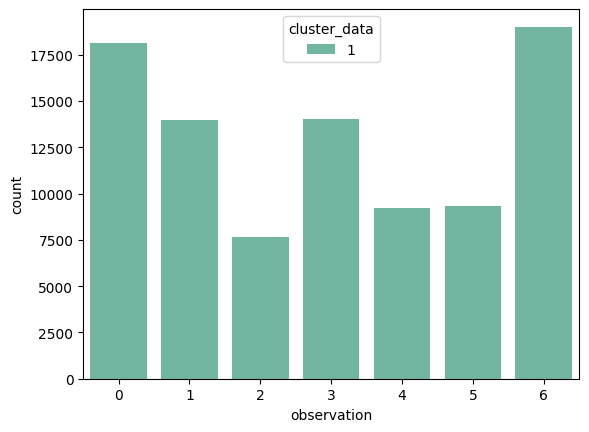

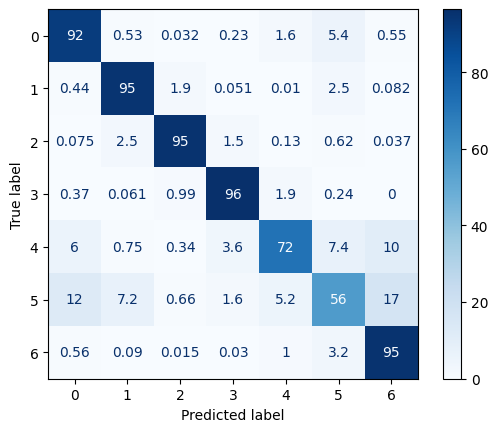

{'average_accuracy': 0.879082305886027, 'average_f1_macro': 0.8559766690628221, 'average_f1_micro': 0.879082305886027, 'average_auc': 0.9749412689179718, 'average_acc_kelas_generatif': 0.9588187009279086, 'average_acc_fase_padi': 0.8998291726899668}
{'val_accuracy': 0.8828336594911937, 'val_f1_macro': 0.8626582464981575, 'val_f1_micro': 0.8828336594911937, 'val_auc': 0.9771072732186991, 'val_acc_kelas_generatif': 0.9647082823337413, 'val_acc_fase_padi': 0.9066224743450826, 'val_relative_acc': 99.16226761533164}
CLUSTER:  2


[I 2024-10-16 16:14:08,378] A new study created in memory with name: no-name-9632bf16-3dd8-43dc-abc5-ef997cffa6d3


[1 4 5 3 6 2 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 16:15:06,688] Trial 0 finished with value: 0.7317823833858162 and parameters: {'max_depth': 10, 'learning_rate': 0.052332546634154535, 'reg_lambda': 0.851788974474551, 'min_child_weight': 84}. Best is trial 0 with value: 0.7317823833858162.


[I 2024-10-16 16:16:07,859] Trial 1 finished with value: 0.7291108032219205 and parameters: {'max_depth': 6, 'learning_rate': 0.08948615957449378, 'reg_lambda': 1.0716983429938285, 'min_child_weight': 65}. Best is trial 0 with value: 0.7317823833858162.


[I 2024-10-16 16:16:55,162] Trial 2 finished with value: 0.7288177502730235 and parameters: {'max_depth': 6, 'learning_rate': 0.05341103433473779, 'reg_lambda': 3.077518774066238, 'min_child_weight': 63}. Best is trial 0 with value: 0.7317823833858162.


[I 2024-10-16 16:17:58,016] Trial 3 finished with value: 0.7329707887292926 and parameters: {'max_depth': 8, 'learning_rate': 0.0401556858863999, 'reg_lambda': 2.373513279027832, 'min_child_weight': 69}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:19:15,005] Trial 4 finished with value: 0.7299836433428308 and parameters: {'max_depth': 8, 'learning_rate': 0.02992071927329462, 'reg_lambda': 1.5711815025273188, 'min_child_weight': 99}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:20:05,143] Trial 5 finished with value: 0.731246895150087 and parameters: {'max_depth': 9, 'learning_rate': 0.04356849973209705, 'reg_lambda': 4.296331781952203, 'min_child_weight': 53}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:21:55,638] Trial 6 finished with value: 0.7327799330544528 and parameters: {'max_depth': 9, 'learning_rate': 0.022542703889743047, 'reg_lambda': 3.4319460521102068, 'min_child_weight': 53}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:22:34,151] Trial 7 finished with value: 0.7301810802088792 and parameters: {'max_depth': 7, 'learning_rate': 0.07322941977385615, 'reg_lambda': 3.3411595592248204, 'min_child_weight': 76}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:23:14,650] Trial 8 finished with value: 0.7314872909365984 and parameters: {'max_depth': 8, 'learning_rate': 0.07877570233666975, 'reg_lambda': 0.4162554138882315, 'min_child_weight': 88}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:23:55,712] Trial 9 finished with value: 0.7296767447137363 and parameters: {'max_depth': 9, 'learning_rate': 0.07845896001362869, 'reg_lambda': 0.5443304265027059, 'min_child_weight': 98}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:25:26,825] Trial 10 finished with value: 0.7247873192342759 and parameters: {'max_depth': 7, 'learning_rate': 0.014267049338009322, 'reg_lambda': 1.883561996311847, 'min_child_weight': 67}. Best is trial 3 with value: 0.7329707887292926.


[I 2024-10-16 16:27:20,026] Trial 11 finished with value: 0.733905700040611 and parameters: {'max_depth': 9, 'learning_rate': 0.024937624777154475, 'reg_lambda': 4.283944739404182, 'min_child_weight': 51}. Best is trial 11 with value: 0.733905700040611.


[I 2024-10-16 16:28:21,572] Trial 12 finished with value: 0.7341921752627631 and parameters: {'max_depth': 10, 'learning_rate': 0.03584334651434269, 'reg_lambda': 4.928124456138386, 'min_child_weight': 50}. Best is trial 12 with value: 0.7341921752627631.


[I 2024-10-16 16:29:27,326] Trial 13 finished with value: 0.7332713416000742 and parameters: {'max_depth': 10, 'learning_rate': 0.03357774221133566, 'reg_lambda': 4.73685796397142, 'min_child_weight': 51}. Best is trial 12 with value: 0.7341921752627631.


[I 2024-10-16 16:31:16,447] Trial 14 finished with value: 0.733352238996814 and parameters: {'max_depth': 10, 'learning_rate': 0.01944241019761304, 'reg_lambda': 4.176455934322515, 'min_child_weight': 59}. Best is trial 12 with value: 0.7341921752627631.


[I 2024-10-16 16:33:26,195] Trial 15 finished with value: 0.726981259268098 and parameters: {'max_depth': 9, 'learning_rate': 0.010801358641490415, 'reg_lambda': 4.977843555606702, 'min_child_weight': 57}. Best is trial 12 with value: 0.7341921752627631.


[I 2024-10-16 16:34:45,016] Trial 16 finished with value: 0.7333873357223624 and parameters: {'max_depth': 10, 'learning_rate': 0.030082889142156753, 'reg_lambda': 4.042363897863023, 'min_child_weight': 74}. Best is trial 12 with value: 0.7341921752627631.


[I 2024-10-16 16:35:21,632] Trial 17 finished with value: 0.7309979418221454 and parameters: {'max_depth': 9, 'learning_rate': 0.06129569519098308, 'reg_lambda': 3.7542752308514835, 'min_child_weight': 59}. Best is trial 12 with value: 0.7341921752627631.


[I 2024-10-16 16:36:03,322] Trial 18 finished with value: 0.7345212511477314 and parameters: {'max_depth': 10, 'learning_rate': 0.043425812520620624, 'reg_lambda': 4.627311155128478, 'min_child_weight': 50}. Best is trial 18 with value: 0.7345212511477314.


[I 2024-10-16 16:36:40,243] Trial 19 finished with value: 0.7325308673235535 and parameters: {'max_depth': 10, 'learning_rate': 0.062057535448959714, 'reg_lambda': 2.7448034996972286, 'min_child_weight': 78}. Best is trial 18 with value: 0.7345212511477314.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.043425812520620624, 'reg_lambda': 4.627311155128478, 'min_child_weight': 50}
Best Score: 0.7345212511477314
Start the modelling


[0]	train-mlogloss:1.86814	eval-mlogloss:1.87719


[100]	train-mlogloss:0.35992	eval-mlogloss:0.72644


[200]	train-mlogloss:0.20741	eval-mlogloss:0.67208


[300]	train-mlogloss:0.13667	eval-mlogloss:0.66134


[400]	train-mlogloss:0.09652	eval-mlogloss:0.65979


[500]	train-mlogloss:0.07246	eval-mlogloss:0.66315


[600]	train-mlogloss:0.05712	eval-mlogloss:0.66932


[700]	train-mlogloss:0.04657	eval-mlogloss:0.67603


[800]	train-mlogloss:0.03955	eval-mlogloss:0.68411


[900]	train-mlogloss:0.03401	eval-mlogloss:0.69131


[1000]	train-mlogloss:0.02980	eval-mlogloss:0.69816


[1100]	train-mlogloss:0.02653	eval-mlogloss:0.70500


[1200]	train-mlogloss:0.02390	eval-mlogloss:0.71143


[1300]	train-mlogloss:0.02172	eval-mlogloss:0.71810


[1370]	train-mlogloss:0.02041	eval-mlogloss:0.72207


[0]	train-mlogloss:1.86795	eval-mlogloss:1.87660


[100]	train-mlogloss:0.35259	eval-mlogloss:0.72108


[200]	train-mlogloss:0.20528	eval-mlogloss:0.66870


[300]	train-mlogloss:0.13446	eval-mlogloss:0.65938


[400]	train-mlogloss:0.09600	eval-mlogloss:0.66186


[500]	train-mlogloss:0.07213	eval-mlogloss:0.66727


[600]	train-mlogloss:0.05668	eval-mlogloss:0.67527


[700]	train-mlogloss:0.04683	eval-mlogloss:0.68339


[800]	train-mlogloss:0.03962	eval-mlogloss:0.69122


[900]	train-mlogloss:0.03427	eval-mlogloss:0.69907


[1000]	train-mlogloss:0.03012	eval-mlogloss:0.70685


[1100]	train-mlogloss:0.02679	eval-mlogloss:0.71382


[1200]	train-mlogloss:0.02407	eval-mlogloss:0.72095


[1300]	train-mlogloss:0.02193	eval-mlogloss:0.72753


[1314]	train-mlogloss:0.02166	eval-mlogloss:0.72840


[0]	train-mlogloss:1.86868	eval-mlogloss:1.87658


[100]	train-mlogloss:0.35726	eval-mlogloss:0.71459


[200]	train-mlogloss:0.20472	eval-mlogloss:0.65861


[300]	train-mlogloss:0.13455	eval-mlogloss:0.64723


[400]	train-mlogloss:0.09525	eval-mlogloss:0.64562


[500]	train-mlogloss:0.07255	eval-mlogloss:0.64971


[600]	train-mlogloss:0.05761	eval-mlogloss:0.65520


[700]	train-mlogloss:0.04739	eval-mlogloss:0.66305


[800]	train-mlogloss:0.03983	eval-mlogloss:0.66981


[900]	train-mlogloss:0.03431	eval-mlogloss:0.67664


[1000]	train-mlogloss:0.02999	eval-mlogloss:0.68377


[1100]	train-mlogloss:0.02677	eval-mlogloss:0.69024


[1200]	train-mlogloss:0.02405	eval-mlogloss:0.69691


[1300]	train-mlogloss:0.02185	eval-mlogloss:0.70289


[1394]	train-mlogloss:0.02014	eval-mlogloss:0.70799


[0]	train-mlogloss:1.86728	eval-mlogloss:1.87507


[50]	train-mlogloss:0.62836	eval-mlogloss:0.85238


[100]	train-mlogloss:0.38208	eval-mlogloss:0.69902


[150]	train-mlogloss:0.29136	eval-mlogloss:0.65839


[200]	train-mlogloss:0.23662	eval-mlogloss:0.64111


[250]	train-mlogloss:0.19408	eval-mlogloss:0.63133


[300]	train-mlogloss:0.15988	eval-mlogloss:0.62533


[350]	train-mlogloss:0.13296	eval-mlogloss:0.62218


[400]	train-mlogloss:0.11243	eval-mlogloss:0.62087


[450]	train-mlogloss:0.09580	eval-mlogloss:0.62086


[488]	train-mlogloss:0.08635	eval-mlogloss:0.62172



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     12194
           1       0.84      0.89      0.87      4445
           2       0.70      0.62      0.66      5642
           3       0.71      0.64      0.67      5850
           4       0.68      0.63      0.65      5891
           5       0.71      0.62      0.67      5653
           6       0.80      0.94      0.86     12207

    accuracy                           0.78     51882
   macro avg       0.76      0.74      0.75     51882
weighted avg       0.77      0.78      0.78     51882



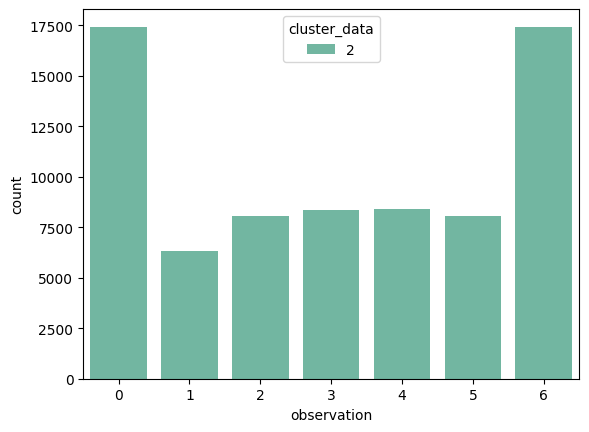

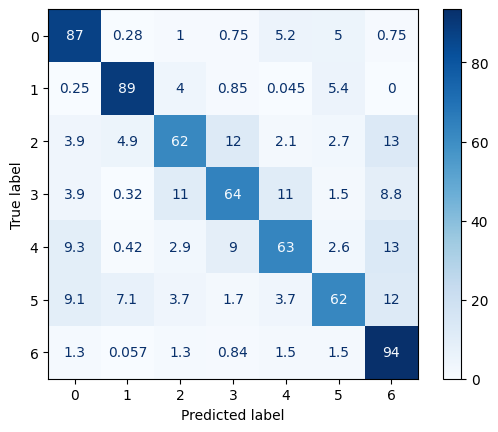

{'average_accuracy': 0.773365172208802, 'average_f1_macro': 0.7384820996104681, 'average_f1_micro': 0.773365172208802, 'average_auc': 0.9517656107470457, 'average_acc_kelas_generatif': 0.6274331719336447, 'average_acc_fase_padi': 0.664528543938422}
{'val_accuracy': 0.7799622219652288, 'val_f1_macro': 0.7492831843860305, 'val_f1_micro': 0.7799622219652288, 'val_auc': 0.9567786827303767, 'val_acc_kelas_generatif': 0.6381196581196581, 'val_acc_fase_padi': 0.6826553051126993, 'val_relative_acc': 96.06410862372707}
CLUSTER:  3


[I 2024-10-16 16:40:01,903] A new study created in memory with name: no-name-6f0a2dcf-3d25-42a0-8535-a6b0ce145355


[6 3 1 4 0 2 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 16:40:29,944] Trial 0 finished with value: 0.8983584369667102 and parameters: {'max_depth': 9, 'learning_rate': 0.08336676362866398, 'reg_lambda': 3.121600234762223, 'min_child_weight': 82}. Best is trial 0 with value: 0.8983584369667102.


[I 2024-10-16 16:41:00,907] Trial 1 finished with value: 0.8996860610166187 and parameters: {'max_depth': 7, 'learning_rate': 0.08399059601944997, 'reg_lambda': 2.1486978176392233, 'min_child_weight': 74}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:43:12,143] Trial 2 finished with value: 0.8973795894313357 and parameters: {'max_depth': 10, 'learning_rate': 0.01785407555381624, 'reg_lambda': 1.9624170741921925, 'min_child_weight': 83}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:44:54,866] Trial 3 finished with value: 0.8952768669553727 and parameters: {'max_depth': 8, 'learning_rate': 0.01744403952455087, 'reg_lambda': 0.3915775209716371, 'min_child_weight': 100}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:46:43,311] Trial 4 finished with value: 0.8966826518789964 and parameters: {'max_depth': 9, 'learning_rate': 0.015427358651381036, 'reg_lambda': 4.87994440573689, 'min_child_weight': 93}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:47:26,579] Trial 5 finished with value: 0.8984047309131481 and parameters: {'max_depth': 8, 'learning_rate': 0.08179063491161358, 'reg_lambda': 2.534732450319096, 'min_child_weight': 95}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:48:20,264] Trial 6 finished with value: 0.8990334235197014 and parameters: {'max_depth': 10, 'learning_rate': 0.04824837835831725, 'reg_lambda': 3.970703672873204, 'min_child_weight': 72}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:48:57,698] Trial 7 finished with value: 0.8985283585939595 and parameters: {'max_depth': 7, 'learning_rate': 0.0849848271252607, 'reg_lambda': 4.526201346128909, 'min_child_weight': 84}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:51:06,244] Trial 8 finished with value: 0.8985657441775006 and parameters: {'max_depth': 10, 'learning_rate': 0.025531045400320772, 'reg_lambda': 4.562394237420832, 'min_child_weight': 75}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:52:47,954] Trial 9 finished with value: 0.8937760995854958 and parameters: {'max_depth': 7, 'learning_rate': 0.01469069688049681, 'reg_lambda': 2.1167467570768554, 'min_child_weight': 74}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:53:09,436] Trial 10 finished with value: 0.8993224199726445 and parameters: {'max_depth': 6, 'learning_rate': 0.09971462610866559, 'reg_lambda': 1.0006605998896496, 'min_child_weight': 55}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:53:34,781] Trial 11 finished with value: 0.8989468407197702 and parameters: {'max_depth': 6, 'learning_rate': 0.09920468459909448, 'reg_lambda': 0.846481527465784, 'min_child_weight': 54}. Best is trial 1 with value: 0.8996860610166187.


[I 2024-10-16 16:54:04,080] Trial 12 finished with value: 0.9001802365425293 and parameters: {'max_depth': 6, 'learning_rate': 0.09983000833217476, 'reg_lambda': 1.259048447578058, 'min_child_weight': 55}. Best is trial 12 with value: 0.9001802365425293.


[I 2024-10-16 16:54:55,513] Trial 13 finished with value: 0.8997111282032065 and parameters: {'max_depth': 7, 'learning_rate': 0.06246101394671262, 'reg_lambda': 1.4621019098829802, 'min_child_weight': 63}. Best is trial 12 with value: 0.9001802365425293.


[I 2024-10-16 16:55:55,799] Trial 14 finished with value: 0.8977571679320265 and parameters: {'max_depth': 6, 'learning_rate': 0.05771945454340169, 'reg_lambda': 1.4635846128829804, 'min_child_weight': 62}. Best is trial 12 with value: 0.9001802365425293.


[I 2024-10-16 16:56:55,519] Trial 15 finished with value: 0.8998637338754044 and parameters: {'max_depth': 7, 'learning_rate': 0.05976224692133192, 'reg_lambda': 0.12534936618844172, 'min_child_weight': 63}. Best is trial 12 with value: 0.9001802365425293.


[I 2024-10-16 16:57:59,258] Trial 16 finished with value: 0.8996486650743645 and parameters: {'max_depth': 6, 'learning_rate': 0.04369014439096005, 'reg_lambda': 0.15543959767811005, 'min_child_weight': 50}. Best is trial 12 with value: 0.9001802365425293.


[I 2024-10-16 16:58:40,381] Trial 17 finished with value: 0.900097370188147 and parameters: {'max_depth': 7, 'learning_rate': 0.07208063880734965, 'reg_lambda': 0.8166922390822657, 'min_child_weight': 61}. Best is trial 12 with value: 0.9001802365425293.


[I 2024-10-16 16:59:17,483] Trial 18 finished with value: 0.89990009682839 and parameters: {'max_depth': 8, 'learning_rate': 0.07121321932063965, 'reg_lambda': 3.1043629185368222, 'min_child_weight': 68}. Best is trial 12 with value: 0.9001802365425293.


[I 2024-10-16 16:59:59,888] Trial 19 finished with value: 0.898696328871495 and parameters: {'max_depth': 6, 'learning_rate': 0.07230307115055325, 'reg_lambda': 0.8981853538267236, 'min_child_weight': 60}. Best is trial 12 with value: 0.9001802365425293.


Best Parameters: {'max_depth': 6, 'learning_rate': 0.09983000833217476, 'reg_lambda': 1.259048447578058, 'min_child_weight': 55}
Best Score: 0.9001802365425293
Start the modelling


[0]	train-mlogloss:1.72600	eval-mlogloss:1.73916


[100]	train-mlogloss:0.14888	eval-mlogloss:0.31933


[200]	train-mlogloss:0.07538	eval-mlogloss:0.28733


[300]	train-mlogloss:0.04496	eval-mlogloss:0.28164


[400]	train-mlogloss:0.03098	eval-mlogloss:0.28242


[500]	train-mlogloss:0.02366	eval-mlogloss:0.28556


[600]	train-mlogloss:0.01850	eval-mlogloss:0.28915


[700]	train-mlogloss:0.01529	eval-mlogloss:0.29274


[800]	train-mlogloss:0.01305	eval-mlogloss:0.29629


[900]	train-mlogloss:0.01153	eval-mlogloss:0.29907


[1000]	train-mlogloss:0.01038	eval-mlogloss:0.30186


[1100]	train-mlogloss:0.00937	eval-mlogloss:0.30467


[1200]	train-mlogloss:0.00856	eval-mlogloss:0.30770


[1300]	train-mlogloss:0.00793	eval-mlogloss:0.31038


[1331]	train-mlogloss:0.00776	eval-mlogloss:0.31110


[0]	train-mlogloss:1.72445	eval-mlogloss:1.73663


[100]	train-mlogloss:0.15243	eval-mlogloss:0.30644


[200]	train-mlogloss:0.07594	eval-mlogloss:0.27553


[300]	train-mlogloss:0.04566	eval-mlogloss:0.26780


[400]	train-mlogloss:0.03174	eval-mlogloss:0.26816


[500]	train-mlogloss:0.02390	eval-mlogloss:0.27078


[600]	train-mlogloss:0.01887	eval-mlogloss:0.27430


[700]	train-mlogloss:0.01578	eval-mlogloss:0.27797


[800]	train-mlogloss:0.01366	eval-mlogloss:0.28133


[900]	train-mlogloss:0.01197	eval-mlogloss:0.28445


[1000]	train-mlogloss:0.01061	eval-mlogloss:0.28750


[1100]	train-mlogloss:0.00959	eval-mlogloss:0.29045


[1200]	train-mlogloss:0.00881	eval-mlogloss:0.29305


[1300]	train-mlogloss:0.00814	eval-mlogloss:0.29563


[1331]	train-mlogloss:0.00794	eval-mlogloss:0.29639


[0]	train-mlogloss:1.72599	eval-mlogloss:1.73866


[100]	train-mlogloss:0.14330	eval-mlogloss:0.30597


[200]	train-mlogloss:0.07215	eval-mlogloss:0.27760


[300]	train-mlogloss:0.04393	eval-mlogloss:0.27394


[400]	train-mlogloss:0.03033	eval-mlogloss:0.27697


[500]	train-mlogloss:0.02290	eval-mlogloss:0.28044


[600]	train-mlogloss:0.01836	eval-mlogloss:0.28456


[700]	train-mlogloss:0.01516	eval-mlogloss:0.28875


[800]	train-mlogloss:0.01303	eval-mlogloss:0.29361


[900]	train-mlogloss:0.01131	eval-mlogloss:0.29821


[1000]	train-mlogloss:0.01005	eval-mlogloss:0.30193


[1100]	train-mlogloss:0.00909	eval-mlogloss:0.30510


[1200]	train-mlogloss:0.00832	eval-mlogloss:0.30826


[1293]	train-mlogloss:0.00777	eval-mlogloss:0.31033


[0]	train-mlogloss:1.72551	eval-mlogloss:1.73692


[50]	train-mlogloss:0.26697	eval-mlogloss:0.36822


[100]	train-mlogloss:0.16663	eval-mlogloss:0.29314


[150]	train-mlogloss:0.12112	eval-mlogloss:0.26974


[200]	train-mlogloss:0.09066	eval-mlogloss:0.25735


[250]	train-mlogloss:0.06964	eval-mlogloss:0.24980


[300]	train-mlogloss:0.05583	eval-mlogloss:0.24614


[350]	train-mlogloss:0.04624	eval-mlogloss:0.24451


[400]	train-mlogloss:0.03878	eval-mlogloss:0.24393


[450]	train-mlogloss:0.03290	eval-mlogloss:0.24404


[481]	train-mlogloss:0.02968	eval-mlogloss:0.24438



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12816
           1       0.95      0.97      0.96     10671
           2       0.93      0.94      0.94      6606
           3       0.93      0.95      0.94     10453
           4       0.93      0.95      0.94     10836
           5       0.93      0.95      0.94      4497
           6       0.80      0.73      0.77      6666

    accuracy                           0.91     62545
   macro avg       0.91      0.91      0.91     62545
weighted avg       0.91      0.91      0.91     62545



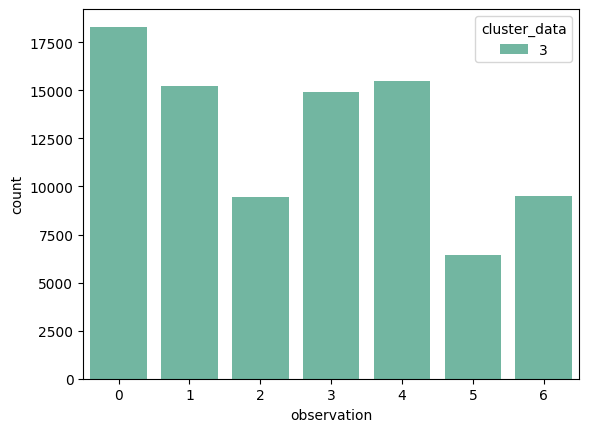

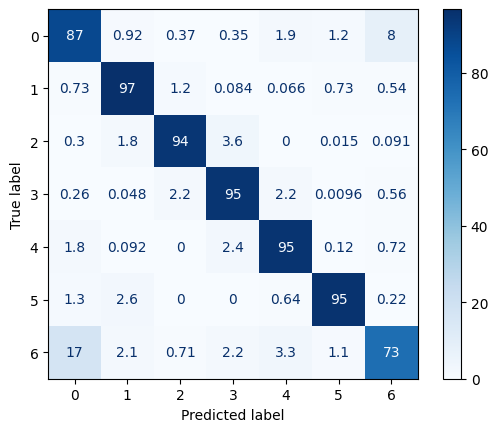

{'average_accuracy': 0.906207861359894, 'average_f1_macro': 0.9013060411749709, 'average_f1_micro': 0.906207861359894, 'average_auc': 0.9886582482324971, 'average_acc_kelas_generatif': 0.9437511899200582, 'average_acc_fase_padi': 0.9496009544056471}
{'val_accuracy': 0.9127827963866016, 'val_f1_macro': 0.9089535041023575, 'val_f1_micro': 0.9127827963866016, 'val_auc': 0.9909863400060598, 'val_acc_kelas_generatif': 0.9470965273127332, 'val_acc_fase_padi': 0.9520302857439196, 'val_relative_acc': 99.92229992229993}
CLUSTER:  4


[I 2024-10-16 17:02:38,170] A new study created in memory with name: no-name-2dbde144-557f-4130-9a88-eca4118d19b7


[0 2 1 3 4 6 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 17:04:12,569] Trial 0 finished with value: 0.9639883986506321 and parameters: {'max_depth': 6, 'learning_rate': 0.024894990849363613, 'reg_lambda': 0.9980363438478806, 'min_child_weight': 61}. Best is trial 0 with value: 0.9639883986506321.


[I 2024-10-16 17:04:49,948] Trial 1 finished with value: 0.9658529203698465 and parameters: {'max_depth': 6, 'learning_rate': 0.09978245275239626, 'reg_lambda': 1.2548875989830552, 'min_child_weight': 56}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:06:19,334] Trial 2 finished with value: 0.9652706460733583 and parameters: {'max_depth': 9, 'learning_rate': 0.023193434565422825, 'reg_lambda': 0.8276494453725025, 'min_child_weight': 68}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:08:12,042] Trial 3 finished with value: 0.9649660607290002 and parameters: {'max_depth': 6, 'learning_rate': 0.034792085246846495, 'reg_lambda': 3.7704369161799027, 'min_child_weight': 54}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:09:06,638] Trial 4 finished with value: 0.9655282192659046 and parameters: {'max_depth': 8, 'learning_rate': 0.05868385083786465, 'reg_lambda': 0.8915817208569621, 'min_child_weight': 70}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:10:02,986] Trial 5 finished with value: 0.9653318247962104 and parameters: {'max_depth': 7, 'learning_rate': 0.0626138567576201, 'reg_lambda': 2.0907816671962736, 'min_child_weight': 53}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:11:04,956] Trial 6 finished with value: 0.966751523767003 and parameters: {'max_depth': 8, 'learning_rate': 0.05809987272179141, 'reg_lambda': 1.186729164320424, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:11:39,880] Trial 7 finished with value: 0.9655303612510369 and parameters: {'max_depth': 6, 'learning_rate': 0.0942061370232696, 'reg_lambda': 1.9261284081318397, 'min_child_weight': 67}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:12:19,210] Trial 8 finished with value: 0.9655767239032983 and parameters: {'max_depth': 6, 'learning_rate': 0.0957988405843492, 'reg_lambda': 0.2918945949474815, 'min_child_weight': 90}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:13:00,875] Trial 9 finished with value: 0.9652519486583193 and parameters: {'max_depth': 7, 'learning_rate': 0.08790848825535812, 'reg_lambda': 4.504983880513354, 'min_child_weight': 98}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:13:56,968] Trial 10 finished with value: 0.9655166943196667 and parameters: {'max_depth': 10, 'learning_rate': 0.07223022785387949, 'reg_lambda': 3.1613671013290565, 'min_child_weight': 82}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:15:24,236] Trial 11 finished with value: 0.9661847656484128 and parameters: {'max_depth': 8, 'learning_rate': 0.04099940650196007, 'reg_lambda': 1.6876694903582456, 'min_child_weight': 53}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:16:54,943] Trial 12 finished with value: 0.9662971592398654 and parameters: {'max_depth': 8, 'learning_rate': 0.04111130387495585, 'reg_lambda': 2.6356674941868503, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:18:14,368] Trial 13 finished with value: 0.9659079631942834 and parameters: {'max_depth': 8, 'learning_rate': 0.04923321286998059, 'reg_lambda': 2.892668692147892, 'min_child_weight': 79}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:18:57,593] Trial 14 finished with value: 0.9662141932151987 and parameters: {'max_depth': 9, 'learning_rate': 0.07608143826697114, 'reg_lambda': 2.5889153966055884, 'min_child_weight': 60}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:21:22,679] Trial 15 finished with value: 0.9613848576270442 and parameters: {'max_depth': 9, 'learning_rate': 0.01030811773602007, 'reg_lambda': 3.6185225912953896, 'min_child_weight': 62}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:22:24,294] Trial 16 finished with value: 0.9657023637855771 and parameters: {'max_depth': 7, 'learning_rate': 0.0483807679383628, 'reg_lambda': 2.253586439576864, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:23:05,252] Trial 17 finished with value: 0.9659923258129695 and parameters: {'max_depth': 10, 'learning_rate': 0.06977581495256693, 'reg_lambda': 0.18093962534766872, 'min_child_weight': 74}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:24:57,162] Trial 18 finished with value: 0.9661191137652295 and parameters: {'max_depth': 9, 'learning_rate': 0.03626677261157158, 'reg_lambda': 4.933504741907167, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:26:09,736] Trial 19 finished with value: 0.9656810055007004 and parameters: {'max_depth': 7, 'learning_rate': 0.05173645371349073, 'reg_lambda': 1.4655785164775275, 'min_child_weight': 63}. Best is trial 6 with value: 0.966751523767003.


Best Parameters: {'max_depth': 8, 'learning_rate': 0.05809987272179141, 'reg_lambda': 1.186729164320424, 'min_child_weight': 50}
Best Score: 0.966751523767003
Start the modelling


[0]	train-mlogloss:1.78588	eval-mlogloss:1.79410


[100]	train-mlogloss:0.05989	eval-mlogloss:0.15571


[200]	train-mlogloss:0.01978	eval-mlogloss:0.11648


[300]	train-mlogloss:0.01149	eval-mlogloss:0.10941


[400]	train-mlogloss:0.00827	eval-mlogloss:0.10704


[500]	train-mlogloss:0.00658	eval-mlogloss:0.10615


[600]	train-mlogloss:0.00558	eval-mlogloss:0.10574


[700]	train-mlogloss:0.00493	eval-mlogloss:0.10591


[800]	train-mlogloss:0.00445	eval-mlogloss:0.10598


[900]	train-mlogloss:0.00409	eval-mlogloss:0.10625


[1000]	train-mlogloss:0.00381	eval-mlogloss:0.10646


[1100]	train-mlogloss:0.00359	eval-mlogloss:0.10664


[1200]	train-mlogloss:0.00340	eval-mlogloss:0.10682


[1300]	train-mlogloss:0.00325	eval-mlogloss:0.10701


[1400]	train-mlogloss:0.00312	eval-mlogloss:0.10731


[1500]	train-mlogloss:0.00301	eval-mlogloss:0.10740


[1558]	train-mlogloss:0.00295	eval-mlogloss:0.10762


[0]	train-mlogloss:1.78472	eval-mlogloss:1.79218


[100]	train-mlogloss:0.05999	eval-mlogloss:0.15012


[200]	train-mlogloss:0.02028	eval-mlogloss:0.11274


[300]	train-mlogloss:0.01164	eval-mlogloss:0.10538


[400]	train-mlogloss:0.00828	eval-mlogloss:0.10309


[500]	train-mlogloss:0.00658	eval-mlogloss:0.10227


[600]	train-mlogloss:0.00554	eval-mlogloss:0.10229


[700]	train-mlogloss:0.00488	eval-mlogloss:0.10244


[800]	train-mlogloss:0.00440	eval-mlogloss:0.10259


[900]	train-mlogloss:0.00405	eval-mlogloss:0.10293


[1000]	train-mlogloss:0.00377	eval-mlogloss:0.10321


[1100]	train-mlogloss:0.00356	eval-mlogloss:0.10339


[1200]	train-mlogloss:0.00338	eval-mlogloss:0.10367


[1300]	train-mlogloss:0.00322	eval-mlogloss:0.10405


[1400]	train-mlogloss:0.00310	eval-mlogloss:0.10424


[1500]	train-mlogloss:0.00299	eval-mlogloss:0.10456


[1600]	train-mlogloss:0.00289	eval-mlogloss:0.10484


[1625]	train-mlogloss:0.00287	eval-mlogloss:0.10495


[0]	train-mlogloss:1.78538	eval-mlogloss:1.79093


[100]	train-mlogloss:0.06188	eval-mlogloss:0.15035


[200]	train-mlogloss:0.02108	eval-mlogloss:0.11319


[300]	train-mlogloss:0.01200	eval-mlogloss:0.10585


[400]	train-mlogloss:0.00855	eval-mlogloss:0.10413


[500]	train-mlogloss:0.00676	eval-mlogloss:0.10355


[600]	train-mlogloss:0.00569	eval-mlogloss:0.10313


[700]	train-mlogloss:0.00498	eval-mlogloss:0.10324


[800]	train-mlogloss:0.00447	eval-mlogloss:0.10336


[900]	train-mlogloss:0.00411	eval-mlogloss:0.10360


[1000]	train-mlogloss:0.00382	eval-mlogloss:0.10389


[1100]	train-mlogloss:0.00360	eval-mlogloss:0.10418


[1200]	train-mlogloss:0.00341	eval-mlogloss:0.10438


[1300]	train-mlogloss:0.00326	eval-mlogloss:0.10471


[1400]	train-mlogloss:0.00313	eval-mlogloss:0.10500


[1500]	train-mlogloss:0.00302	eval-mlogloss:0.10532


[1600]	train-mlogloss:0.00292	eval-mlogloss:0.10542


[1611]	train-mlogloss:0.00291	eval-mlogloss:0.10542


[0]	train-mlogloss:1.78359	eval-mlogloss:1.78928


[50]	train-mlogloss:0.19054	eval-mlogloss:0.26144


[100]	train-mlogloss:0.06178	eval-mlogloss:0.13962


[150]	train-mlogloss:0.03298	eval-mlogloss:0.11320


[200]	train-mlogloss:0.02166	eval-mlogloss:0.10254


[250]	train-mlogloss:0.01554	eval-mlogloss:0.09722


[300]	train-mlogloss:0.01199	eval-mlogloss:0.09444


[350]	train-mlogloss:0.00978	eval-mlogloss:0.09306


[400]	train-mlogloss:0.00825	eval-mlogloss:0.09221


[450]	train-mlogloss:0.00716	eval-mlogloss:0.09176


[500]	train-mlogloss:0.00634	eval-mlogloss:0.09157


[550]	train-mlogloss:0.00571	eval-mlogloss:0.09143


[600]	train-mlogloss:0.00521	eval-mlogloss:0.09143


[636]	train-mlogloss:0.00492	eval-mlogloss:0.09158



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     13824
           1       0.96      0.95      0.96     12382
           2       0.96      0.97      0.96      9003
           3       0.98      0.98      0.98      8310
           4       0.97      0.98      0.98      9441
           5       0.97      0.97      0.97      8912
           6       0.98      0.99      0.99     10548

    accuracy                           0.97     72420
   macro avg       0.97      0.97      0.97     72420
weighted avg       0.97      0.97      0.97     72420



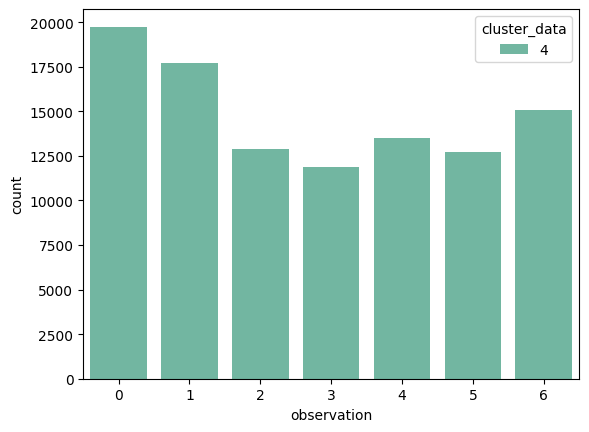

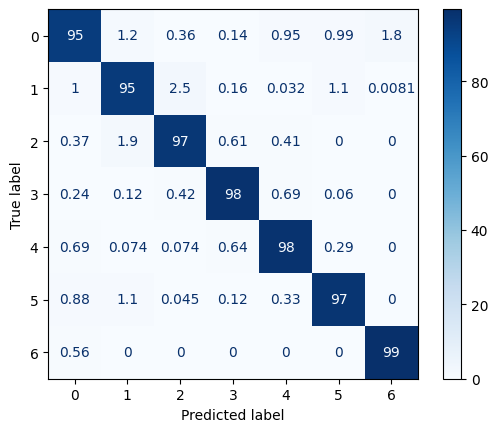

{'average_accuracy': 0.965942818623835, 'average_f1_macro': 0.9670538183098394, 'average_f1_micro': 0.965942818623835, 'average_auc': 0.998772281125114, 'average_acc_kelas_generatif': 0.9817467003650661, 'average_acc_fase_padi': 0.9673284445239373}
{'val_accuracy': 0.9693040596520298, 'val_f1_macro': 0.970398924095045, 'val_f1_micro': 0.9693040596520298, 'val_auc': 0.9990237302143079, 'val_acc_kelas_generatif': 0.9847172081829122, 'val_acc_fase_padi': 0.9696187653311529, 'val_relative_acc': 99.7799849132512}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [11]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)

In [3]:
with open("/data/ksa/05_Modelling/model/xgboost16_v2.pkl", 'rb') as f:
    dict_report = pickle.load(f)

In [4]:
dict_report

{0: {'model': <xgboost.core.Booster at 0x7f435c63db10>,
  'training_metrics': {'average_accuracy': 0.8199170539149553,
   'average_f1_macro': 0.8102704443209419,
   'average_f1_micro': 0.8199170539149553,
   'average_auc': 0.9655707423313302,
   'average_acc_kelas_generatif': 0.9126802367479977,
   'average_acc_fase_padi': 0.8972269055887452},
  'validation_metrics': {'val_accuracy': 0.8210630005567691,
   'val_f1_macro': 0.8117666077077271,
   'val_f1_micro': 0.8210630005567691,
   'val_auc': 0.9663542619295706,
   'val_acc_kelas_generatif': 0.9085734000345006,
   'val_acc_fase_padi': 0.9052348774729301,
   'val_relative_acc': 99.52379221345741},
  'reports': '              precision    recall  f1-score   support\n\n           0       0.85      0.88      0.87     10133\n           1       0.88      0.92      0.90      8637\n           2       0.88      0.91      0.89      4765\n           3       0.90      0.91      0.90      5797\n           4       0.87      0.87      0.87      5367

In [6]:
df = pd.DataFrame()
for cluster_id, metrics in dict_report.items():
    # Training metrics
    df.loc[cluster_id, 'ACCURACY'] = metrics['training_metrics']['average_accuracy']
    df.loc[cluster_id, 'F1 MACRO'] = metrics['training_metrics']['average_f1_macro']
    df.loc[cluster_id, 'F1 MICRO'] = metrics['training_metrics']['average_f1_micro']
    df.loc[cluster_id, 'AUC'] = metrics['training_metrics']['average_auc']
    df.loc[cluster_id, 'ACC [GENERATIVE]'] = metrics['training_metrics']['average_acc_kelas_generatif']
    df.loc[cluster_id, '[FASE PADI]'] = metrics['training_metrics']['average_acc_fase_padi']
    
    # Validation metrics
    df.loc[cluster_id, 'VAL ACCURACY'] = metrics['validation_metrics']['val_accuracy']
    df.loc[cluster_id, 'VAL F1 MACRO'] = metrics['validation_metrics']['val_f1_macro']
    df.loc[cluster_id, 'VAL F1 MICRO'] = metrics['validation_metrics']['val_f1_micro']
    df.loc[cluster_id, 'VAL AUC'] = metrics['validation_metrics']['val_auc']
    df.loc[cluster_id, 'VAL ACC [GENERATIVE]'] = metrics['validation_metrics']['val_acc_kelas_generatif']
    df.loc[cluster_id, 'VAL ACC [FASE PADI]'] = metrics['validation_metrics']['val_acc_fase_padi']
    df.loc[cluster_id, 'RELATIVE ACCURACY'] = metrics['validation_metrics']['val_relative_acc']

df.to_csv("Progress16.csv")